In [2]:
#But sometimes people are willing to accept answers provided within certain timeframe,
#so then the question comes down to choosing between answers provided by different users.
#so say a user is willing to accept answers provided within one week, how to distinguish answers?
#how many answers provided by expert vs. others (so there is maximum likelihood to solve the question)? 

import random
import os
import dill
import operator
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from datetime import datetime
import networkx as nx

os.chdir('/home/vagrant/projects/stackoverflow-post')
network = dill.load(open('data/subnetwork.pkd', 'r'))
G = dill.load(open('G.pkd', 'r'))

In [3]:
# names = ['source', 'target', 'time']
# df = pd.read_csv('sx-stackoverflow.txt', sep = ' ', header=None, names = names)
# a2q = pd.read_csv('sx-stackoverflow-a2q.txt', sep = ' ', header=None, names = names)
# c2a = pd.read_csv('sx-stackoverflow-c2a.txt', sep = ' ', header=None, names = names)
# c2q = pd.read_csv('sx-stackoverflow-c2q.txt', sep = ' ', header=None, names = names)
# a2q['type'] = 1 #answer to questions
# c2a['type'] = 2 #comments to answers
# c2q['type'] = 3 #comments to questions
# #merge a2q, c2a, c2q to main to add type column
# df_a2q = df.merge(a2q, on=names, how='left')
# df_a2q_c2a = df_a2q.merge(c2a, on=names,how='left')
# df_all = df_a2q_c2a.merge(c2q, on=names,how='left')
# df_all['type'] = df_all.type_x.fillna(0) + df_all.type_y.fillna(0) + df_all.type.fillna(0)
# network = df[['source', 'target', 'time']]
# dill.dump(network, open('network.pkd', 'w'))

In [4]:
# network = dill.load(open('data/network.pkd', 'r'))

In [5]:
network.head()

,OwnerUserId,ParentId,PostTypeId
0,8,None,1
1,9,None,1
2,9,4,2
3,1,None,1
4,1,None,1


In [34]:
nodes = np.unique(np.concatenate((network.OwnerUserId.unique(), network.ParentId.unique())))
edges = network.apply(lambda row: (row['OwnerUserId'], row['ParentId']) if int(row['PostTypeId']) == 2 else None, axis = 1)

In [43]:
edges = list(edges.dropna())
nodes = list(pd.Series(nodes).dropna())

In [46]:
G=nx.MultiDiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
dill.dump(G, open('G.pkd', 'w'))

In [49]:
G.__len__()

146470

In [74]:
dg = pd.Series([G.degree(node) for node in nodes], name = 'degree', index = nodes)
idg = pd.Series([G.in_degree(node) for node in nodes], name = 'in degree', index = nodes)
odg = pd.Series([G.out_degree(node) for node in nodes], name = 'out degree', index = nodes)
dc = pd.Series(nx.degree_centrality(G), name = 'degree centrality', index = nodes)
idc = pd.Series(nx.in_degree_centrality(G),name = 'in degree centrality', index = nodes)
odc = pd.Series(nx.out_degree_centrality(G),name = 'out degree centrality', index = nodes)

In [79]:
centrality = pd.concat([dg, idg, odg, dc, idc, odc], axis = 1)
dill.dump(centrality, open('centrality.pkd', 'w'))

In [88]:
centrality.sort_values(by='degree centrality', ascending = False).head()

,degree,in degree,out degree,degree centrality,in degree centrality,out degree centrality
22656,2616,0,2616,0.017860,0.000000,0.017860
23354,2050,0,2050,0.013996,0.000000,0.013996
12950,1534,0,1534,0.010473,0.000000,0.010473
3043,1395,0,1395,0.009524,0.000000,0.009524
10661,1105,2,1103,0.007544,0.000014,0.007531


In [122]:
centrality.loc[centrality.degree <= 10, ].sort_values(by = 'degree', ascending = False).head()

,degree,in degree,out degree,degree centrality,in degree centrality,out degree centrality
244645,10,10,0,0.000068,0.000068,0.000000
189087,10,10,0,0.000068,0.000068,0.000000
230241,10,10,0,0.000068,0.000068,0.000000
40361,10,5,5,0.000068,0.000034,0.000034
289329,10,10,0,0.000068,0.000068,0.000000


In [232]:
def addNNeighbors(node):
    allNeighbor = len([i for i in nx.all_neighbors(G, node)])
    outNeighbor = len(nx.neighbors(G, node))
    inNeighbor = allNeighbor - outNeighbor
    return {'allN': allNeighbor, 'outN': outNeighbor, 'inN':inNeighbor};

centrality['allN'] = pd.Series(centrality.apply(lambda row: addNNeighbors(row.name)['allN'], axis = 1))
centrality['outN'] = pd.Series(centrality.apply(lambda row: addNNeighbors(row.name)['outN'], axis = 1))
centrality['inN'] = pd.Series(centrality.apply(lambda row: addNNeighbors(row.name)['inN'], axis = 1))
centrality['avg_n_contact'] = centrality['degree']/centrality['allN']
centrality['avg_n_in_contact'] = centrality['in degree']/centrality['inN']
centrality['avg_n_out_contact'] = centrality['out degree']/centrality['outN']

In [235]:
centrality.sort_values(by='avg_n_contact', ascending = False).head() #max is 7 interactions per user with the same other person

,degree,in degree,out degree,degree centrality,in degree centrality,out degree centrality,allN,outN,inN,avg_n_contact,avg_n_in_contact,avg_n_out_contact
528519,7,7,0,0.000048,0.000048,0.000000,1,0,1,7.000000,7.000000,NaN
Kociub,6,0,6,0.000041,0.000000,0.000041,1,1,0,6.000000,NaN,6.0
Mike Moyle,10,0,10,0.000068,0.000000,0.000068,2,2,0,5.000000,NaN,5.0
211216,13,13,0,0.000089,0.000089,0.000000,3,0,3,4.333333,4.333333,NaN
209778,21,21,0,0.000143,0.000143,0.000000,5,0,5,4.200000,4.200000,NaN


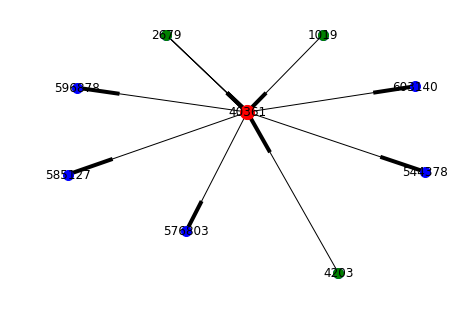

In [237]:
neighbors = [i for i in nx.all_neighbors(G, '40361')] 
# neighbors #8 neighbors but degree = 10, degree takes into account of multiple edges
# len(nx.neighbors(G, '40361')) #number of neighbors for out degree
# len(neighbors) - len(nx.neighbors(G, '40361'))#number of neighbors for in degree
ego = nx.ego_graph(G, '40361', undirected = True)
pos = nx.spring_layout(ego)
nx.draw(ego, pos, node_color='b', node_size = 100, with_labels = True)
nx.draw_networkx_nodes(ego, pos, nodelist = ['40361'], node_size = 200, node_color='r')
nx.draw_networkx_nodes(ego, pos, nodelist = ['1019', '4203', '2679'], node_size = 100, node_color='g')
# nx.draw_networkx_edge_labels(ego, pos, edge_labels = )
plt.figure(figsize=(100,350))
plt.show()

In [236]:
dill.dump(centrality, open('centrality.pkd', 'w'))

In [240]:
centrality.loc[centrality.index == 'essexboyracer',]

,degree,in degree,out degree,degree centrality,in degree centrality,out degree centrality,allN,outN,inN,avg_n_contact,avg_n_in_contact,avg_n_out_contact
essexboyracer,4,0,4,0.000027,0.0,0.000027,4,4,0,1.0,NaN,1.0
